In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve, make_swiss_roll
import torch
import torch.nn as nn

In [21]:
#自定义神经网络
class MLPDiffusion(nn.Module):
    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion, self).__init__()

        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2),
            ]
        )
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
            ]
        )

    def forward(self, x, t):
        # x = x_0
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2 * idx](x)
            x += t_embedding
            x = self.linears[2 * idx + 1](x)

        x = self.linears[-1](x)

        return x

In [25]:
def diffusion_loss_fn(model, x_0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    """对任意时刻t进行采样计算loss"""
    batch_size = x_0.shape[0]

    # 对一个batchsize样本生成随机的时刻t，t变得随机分散一些，一个batch size里面覆盖更多的t
    t = torch.randint(0, n_steps, size=(batch_size // 2,))
    t = torch.cat([t, n_steps - 1 - t], dim=0)# t的形状（bz）
    t = t.unsqueeze(-1)# t的形状（bz,1）

    # x0的系数，根号下(alpha_bar_t)
    a = alphas_bar_sqrt[t]

    # eps的系数,根号下(1-alpha_bar_t)
    aml = one_minus_alphas_bar_sqrt[t]

    # 生成随机噪音eps
    e = torch.randn_like(x_0)

    # 构造模型的输入
    x = x_0 * a + e * aml

    # 送入模型，得到t时刻的随机噪声预测值
    output = model(x, t.squeeze(-1))

    # 与真实噪声一起计算误差，求平均值
    return (e - output).square().mean()

In [27]:
#从xt恢复x0
def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]、x[T-2]|...x[0]"""
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i, betas, one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

In [29]:
def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    """从x[T]采样t时刻的重构值"""
    t = torch.tensor([t])

    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]

    eps_theta = model(x, t)
    #得到均值
    mean = (1 / (1 - betas[t]).sqrt()) * (x - (coeff * eps_theta))

    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()
    #得到sample的分布
    sample = mean + sigma_t * z

    return (sample)

In [2]:
# 生成一万个点，得到s curve
s_curve, _ = make_swiss_roll(10**4,noise=0.1)
s_curve = s_curve[:,[0,2]]/10.0
print("shape of s:",np.shape(s_curve))
data = s_curve.T
# 构建数据集
dataset = torch.Tensor(s_curve).float()

shape of s: (10000, 2)


In [3]:
#确定超参数的值
num_steps = 100  

In [4]:
#制定每一步的beta，beta按照时间从小到大变化
betas = torch.linspace(-6,6,num_steps)  # 使用linespace指定bata的值，也可以用其他方法
betas = torch.sigmoid(betas)*(0.5e-2 - 1e-5)+1e-5

In [5]:
alphas = 1-betas

In [6]:
alphas_prod = torch.cumprod(alphas,0)

In [7]:
alphas.shape

torch.Size([100])

In [8]:
betas.shape

torch.Size([100])

In [9]:
alphas_prod_p = torch.cat([torch.tensor([1]).float(),alphas_prod[:-1]],0)

In [10]:
alphas_bar_sqrt = torch.sqrt(alphas_prod)

In [11]:
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [12]:
assert alphas.shape==alphas_prod.shape==alphas_prod_p.shape==\
alphas_bar_sqrt.shape==one_minus_alphas_bar_log.shape\
==one_minus_alphas_bar_sqrt.shape
print("all the same shape",betas.shape)

all the same shape torch.Size([100])


In [13]:
def q_x(x_0, t):
    """可以基于x[0]得到任意时刻t的x[t]"""
    #生成正态分布采样
    noise = torch.randn_like(x_0)
    #得到均值方差，根据时间步选择alphas_bar_sqrt值和one_minus_alphas_bar_sqrt值
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    #根据x0求xt
    return (alphas_t * x_0 + alphas_1_m_t * noise)  # 在x[0]的基础上添加噪声

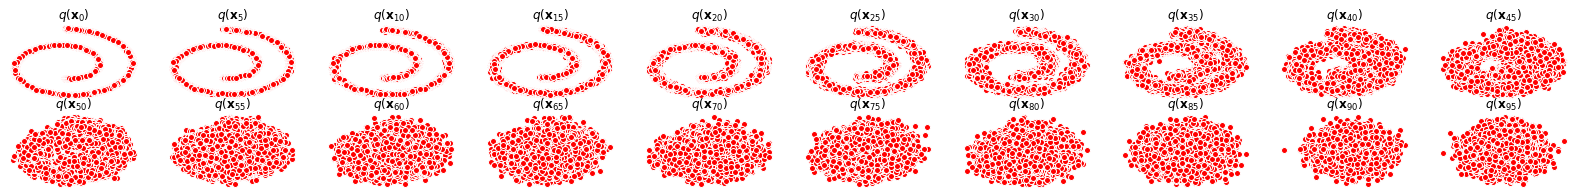

In [18]:
num_shows = 20
fig,axs = plt.subplots(2,10,figsize=(28,3))
plt.rc('text',color='black')
for i in range(num_shows):
    j = i//10
    k = i % 10
    q_i = q_x(dataset,torch.tensor([i*num_steps//num_shows])) # 生成t时刻的采样数据，dataset是起始的x_0, q_x(x_0, t)
    axs[j,k].scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white')
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')
plt.show()

In [23]:
batch_size = 128
# dataset放到dataloader中
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
# 迭代周期
num_epoch = 4000
plt.rc('text', color='blue')
#实例化模型，传入一个数
model = MLPDiffusion(num_steps)  # 输出维度是2，输入是x和step
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

tensor(0.8383, grad_fn=<MeanBackward0>)
tensor(0.6079, grad_fn=<MeanBackward0>)
tensor(0.4177, grad_fn=<MeanBackward0>)
tensor(0.5398, grad_fn=<MeanBackward0>)
tensor(0.3496, grad_fn=<MeanBackward0>)
tensor(0.2836, grad_fn=<MeanBackward0>)
tensor(0.5581, grad_fn=<MeanBackward0>)
tensor(0.5713, grad_fn=<MeanBackward0>)
tensor(0.3947, grad_fn=<MeanBackward0>)
tensor(0.4339, grad_fn=<MeanBackward0>)
tensor(0.7564, grad_fn=<MeanBackward0>)
tensor(0.7106, grad_fn=<MeanBackward0>)
tensor(0.8350, grad_fn=<MeanBackward0>)
tensor(0.3999, grad_fn=<MeanBackward0>)
tensor(0.8256, grad_fn=<MeanBackward0>)
tensor(0.4541, grad_fn=<MeanBackward0>)
tensor(0.3392, grad_fn=<MeanBackward0>)
tensor(0.3932, grad_fn=<MeanBackward0>)
tensor(0.2982, grad_fn=<MeanBackward0>)
tensor(0.5353, grad_fn=<MeanBackward0>)
tensor(0.3901, grad_fn=<MeanBackward0>)


C:\Users\PC\AppData\Local\Temp\ipykernel_2740\146142778.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 10, figsize=(28, 3))


tensor(0.4690, grad_fn=<MeanBackward0>)
tensor(0.3608, grad_fn=<MeanBackward0>)
tensor(0.8697, grad_fn=<MeanBackward0>)
tensor(0.5638, grad_fn=<MeanBackward0>)
tensor(1.2420, grad_fn=<MeanBackward0>)
tensor(0.5209, grad_fn=<MeanBackward0>)
tensor(0.8117, grad_fn=<MeanBackward0>)
tensor(0.7250, grad_fn=<MeanBackward0>)
tensor(0.5383, grad_fn=<MeanBackward0>)
tensor(0.6763, grad_fn=<MeanBackward0>)
tensor(0.4309, grad_fn=<MeanBackward0>)
tensor(0.5374, grad_fn=<MeanBackward0>)
tensor(0.4526, grad_fn=<MeanBackward0>)
tensor(0.4632, grad_fn=<MeanBackward0>)
tensor(1.1093, grad_fn=<MeanBackward0>)
tensor(0.6169, grad_fn=<MeanBackward0>)
tensor(0.4231, grad_fn=<MeanBackward0>)
tensor(0.6619, grad_fn=<MeanBackward0>)
tensor(0.5250, grad_fn=<MeanBackward0>)


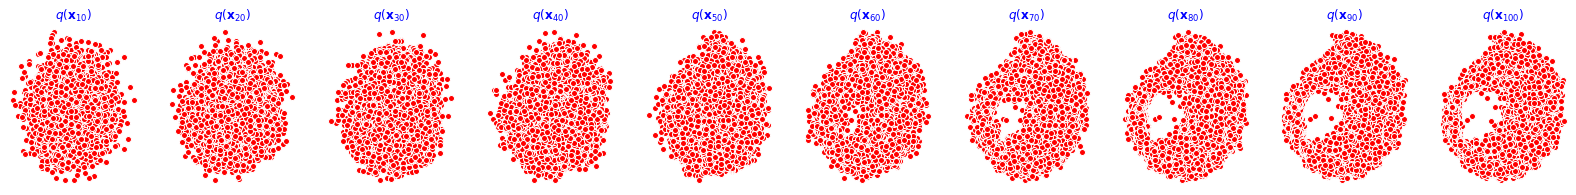

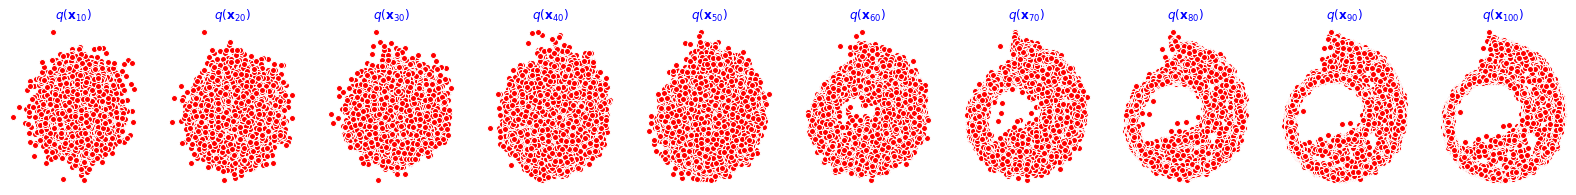

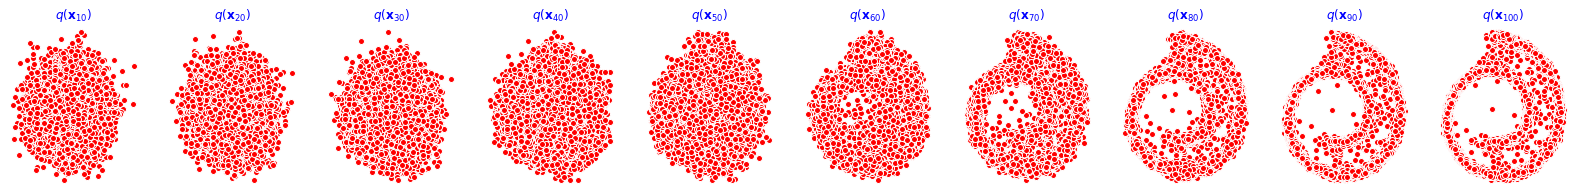

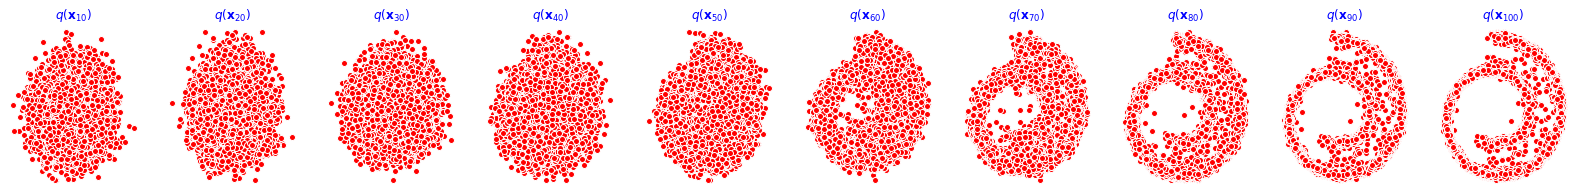

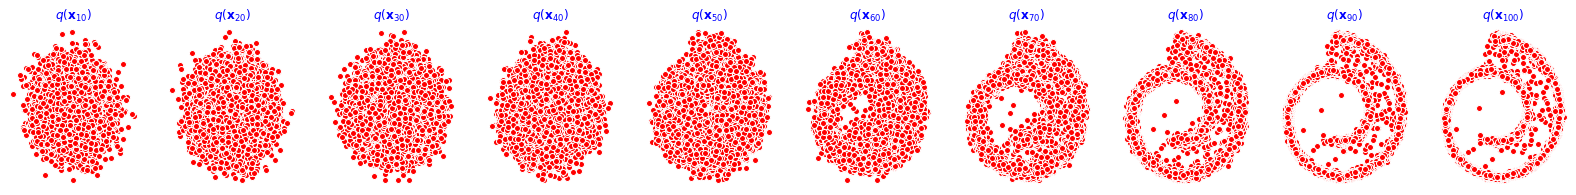

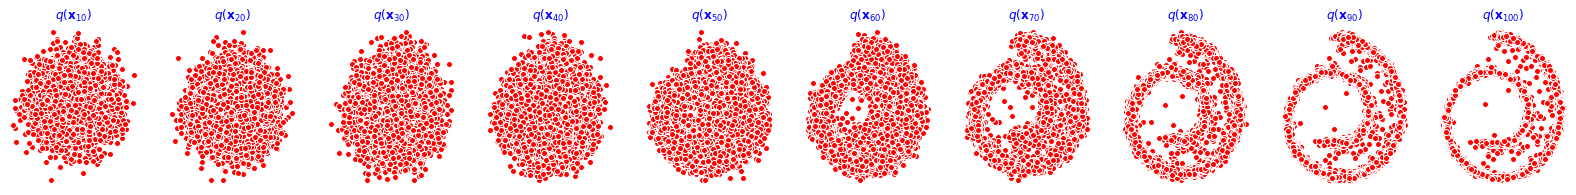

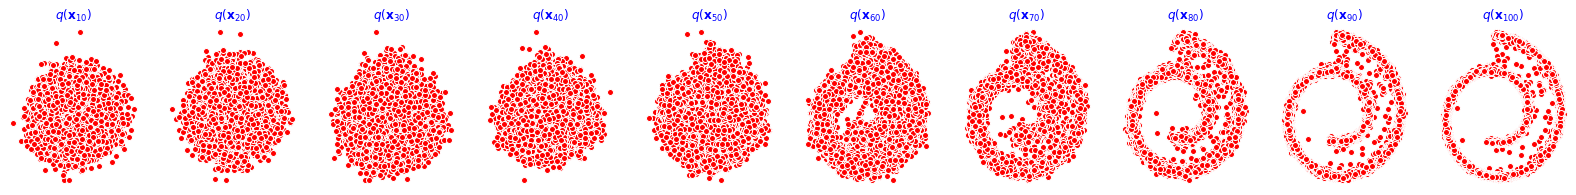

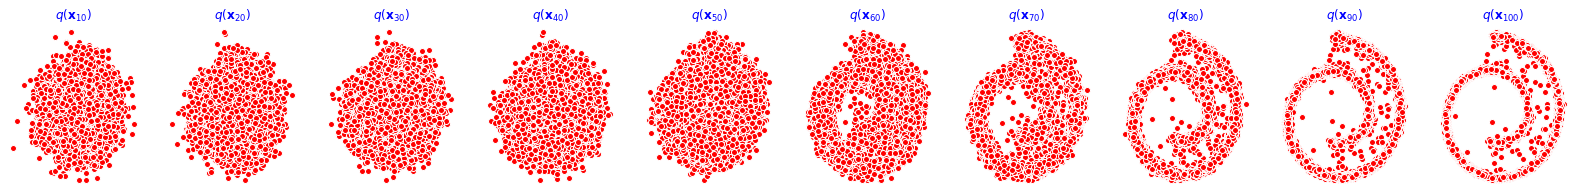

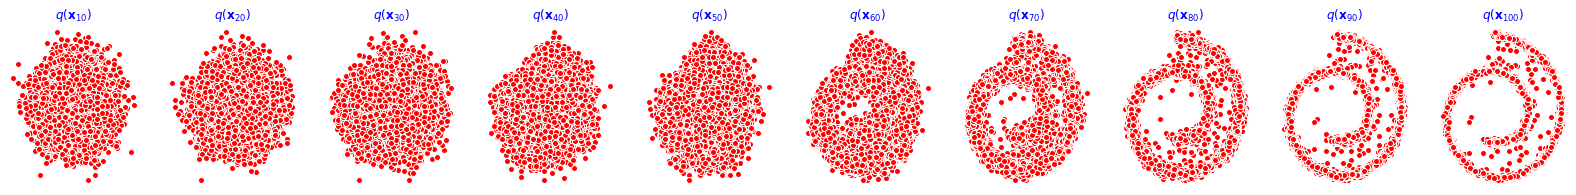

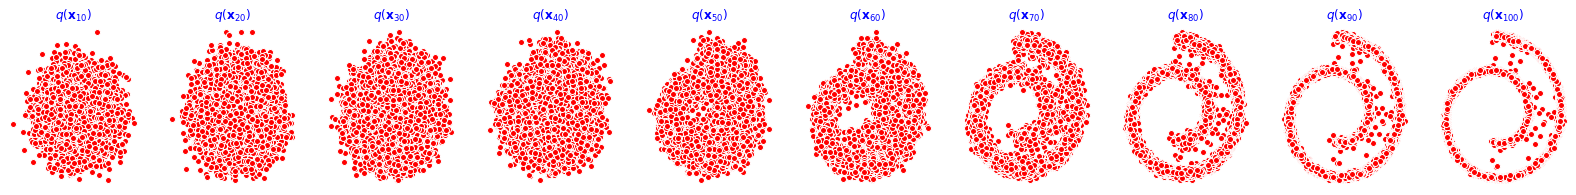

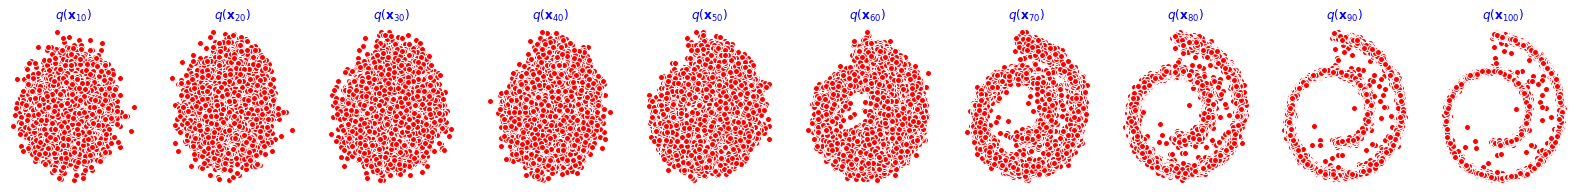

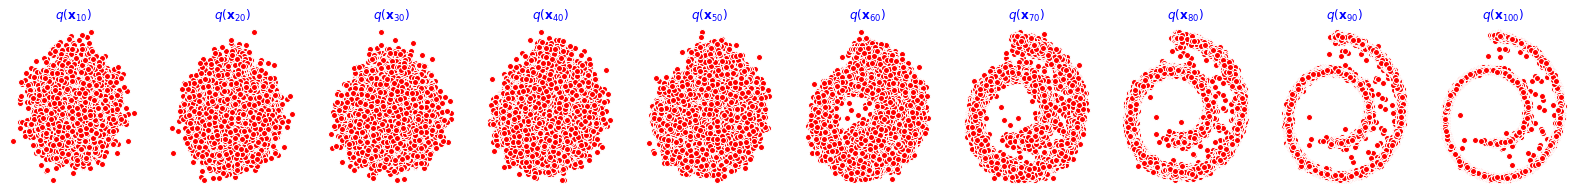

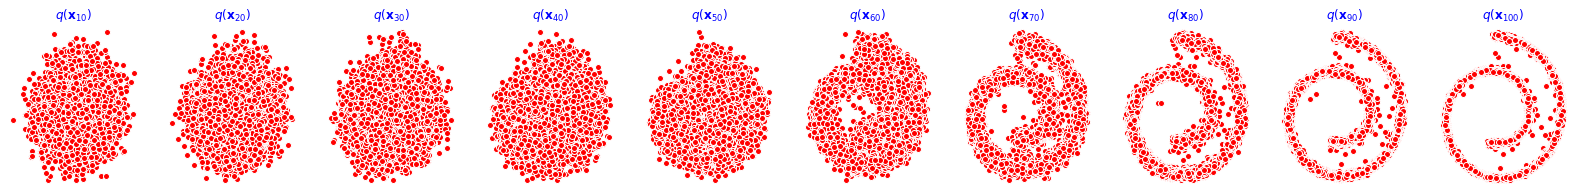

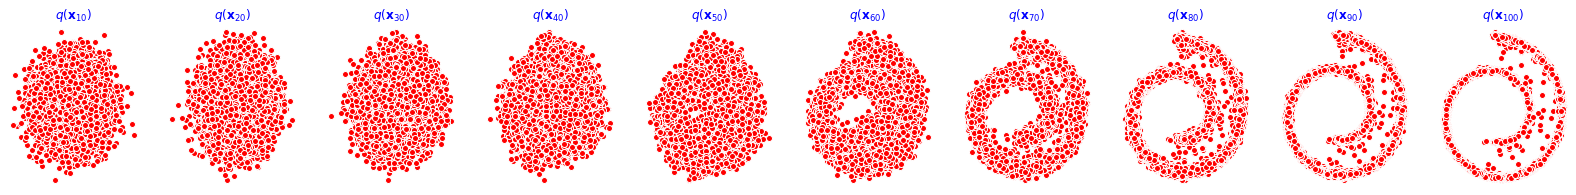

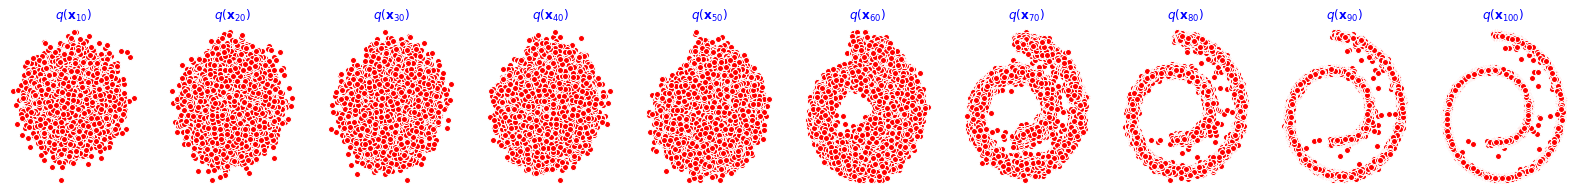

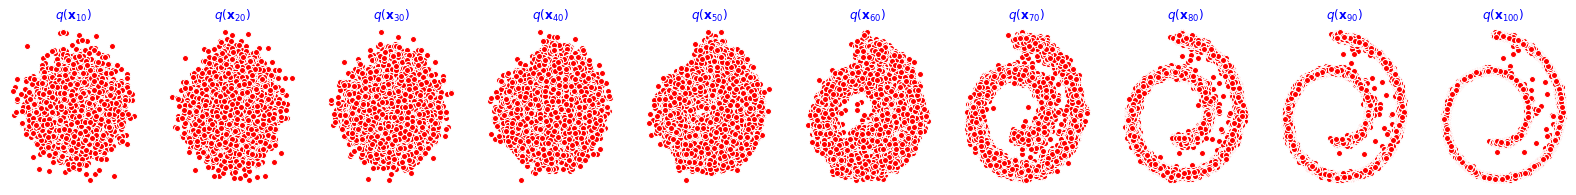

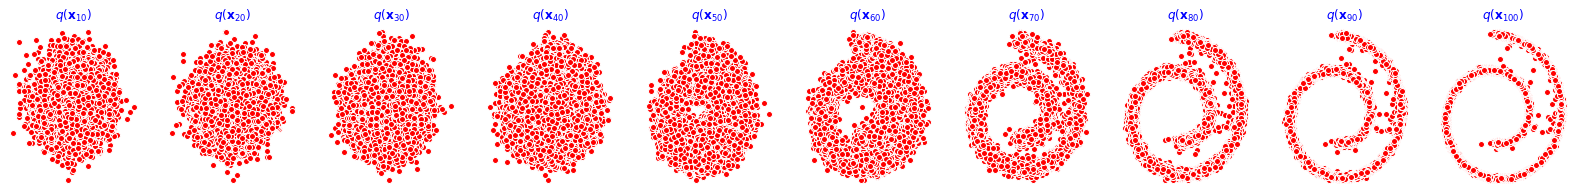

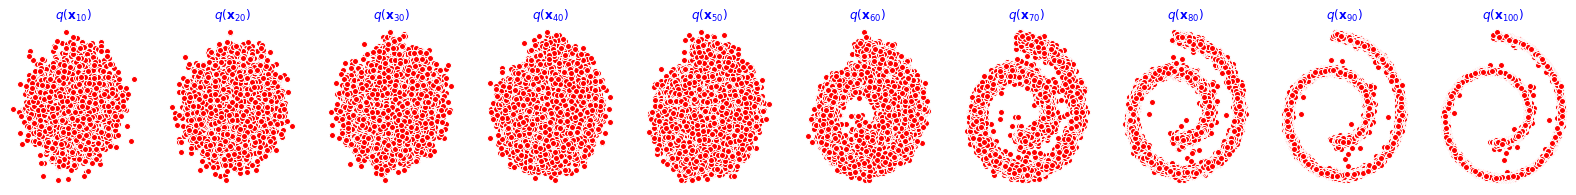

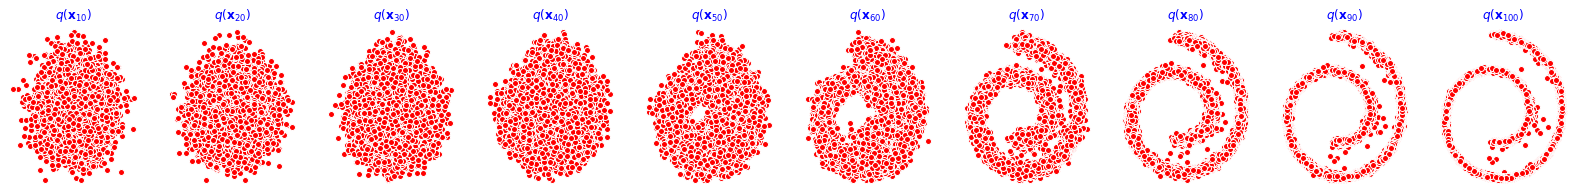

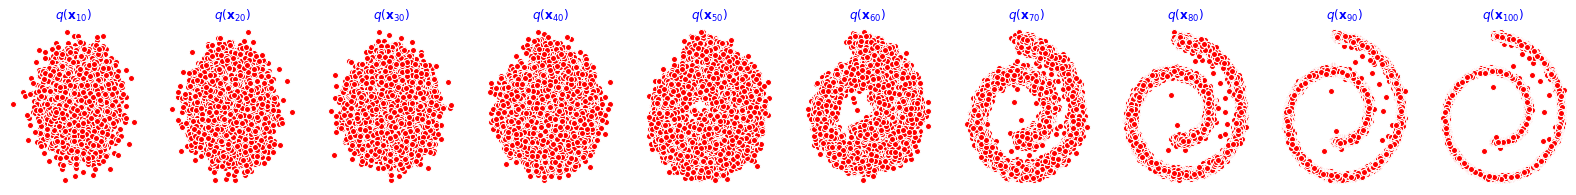

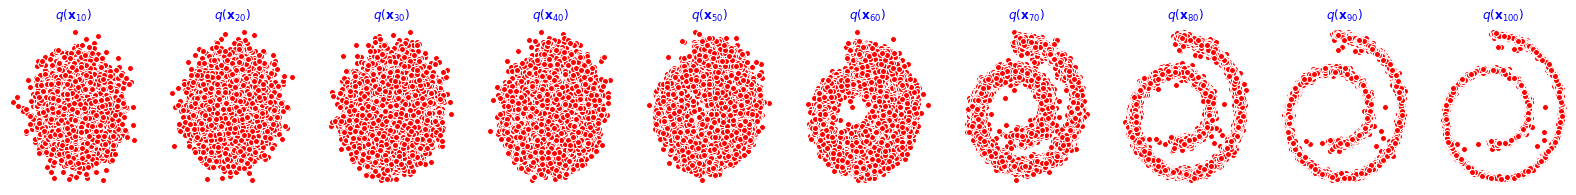

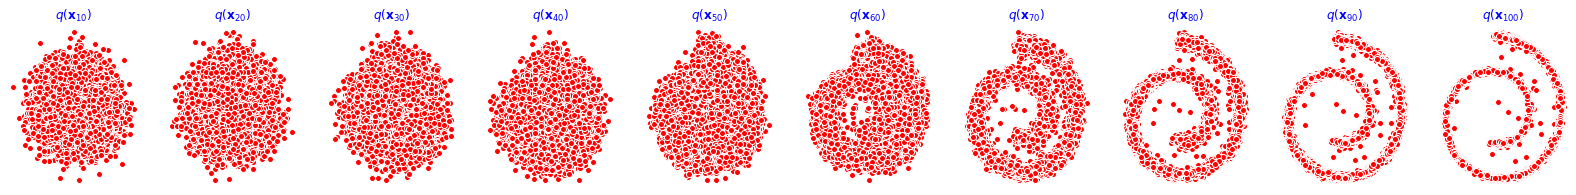

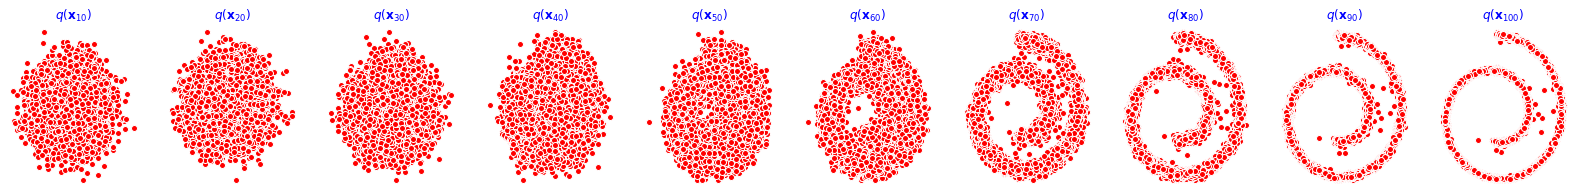

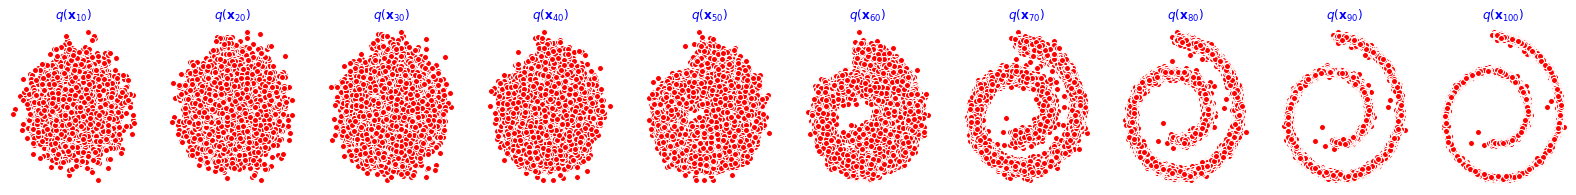

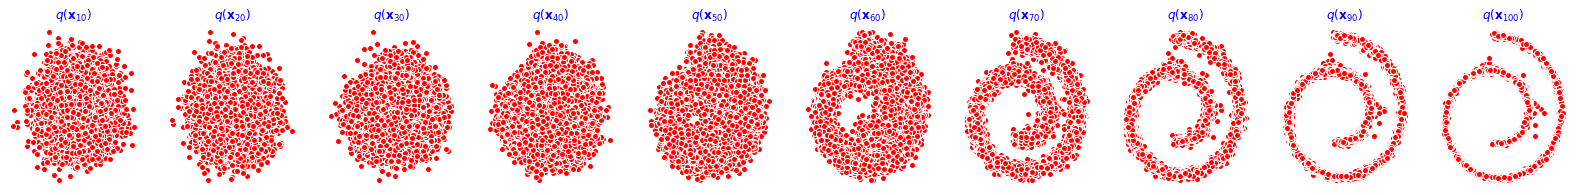

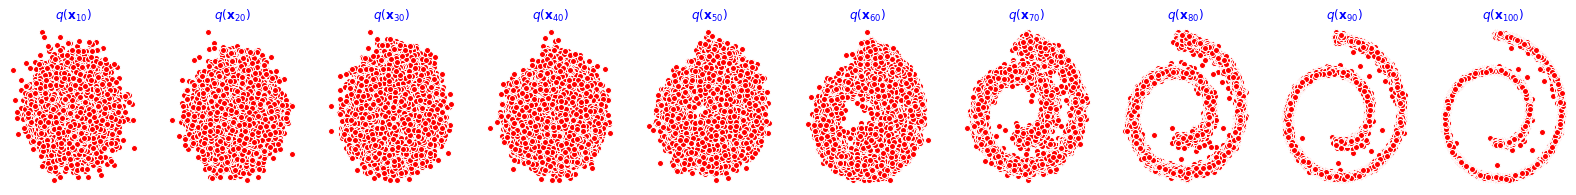

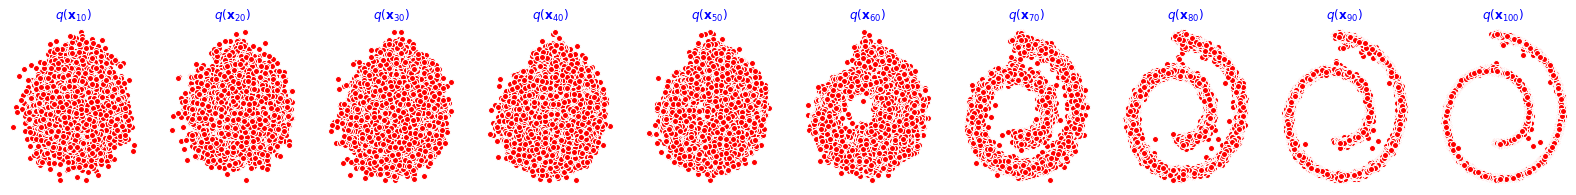

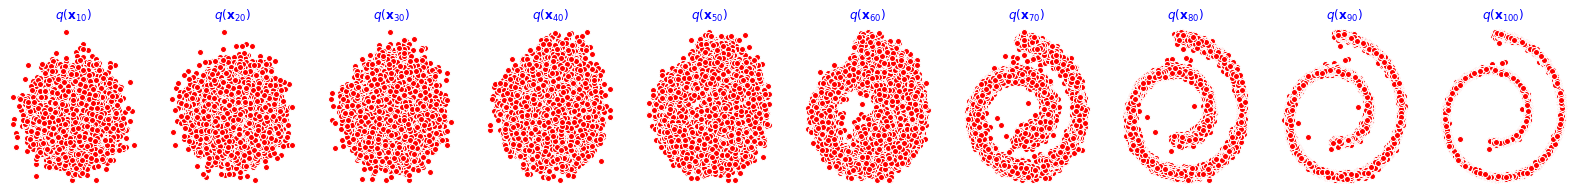

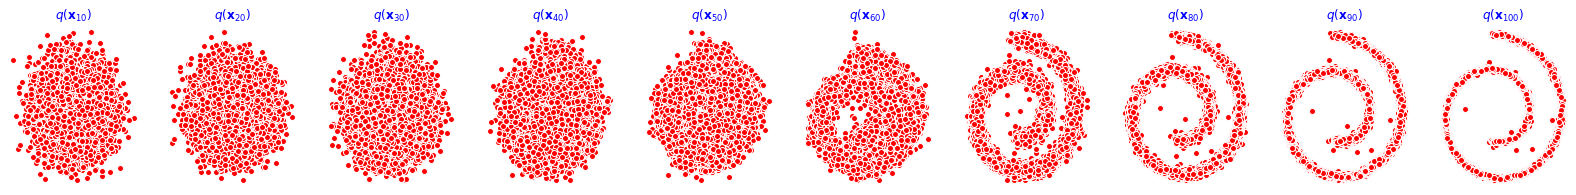

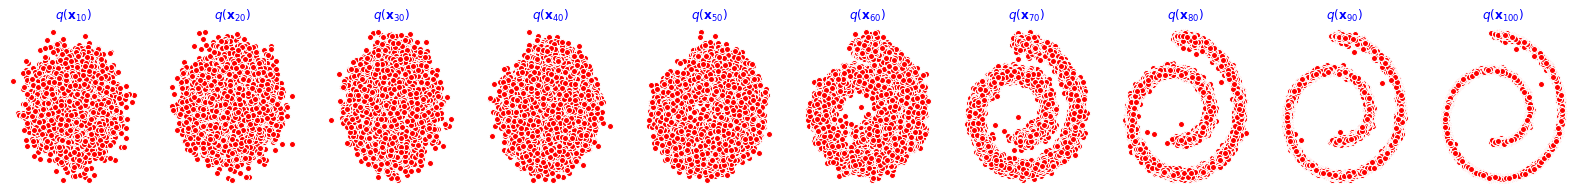

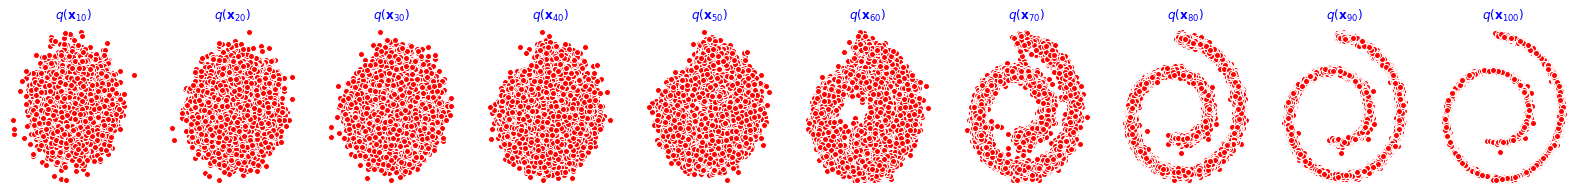

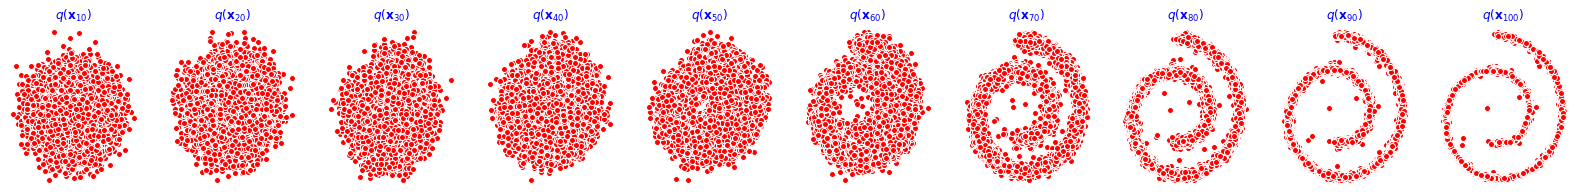

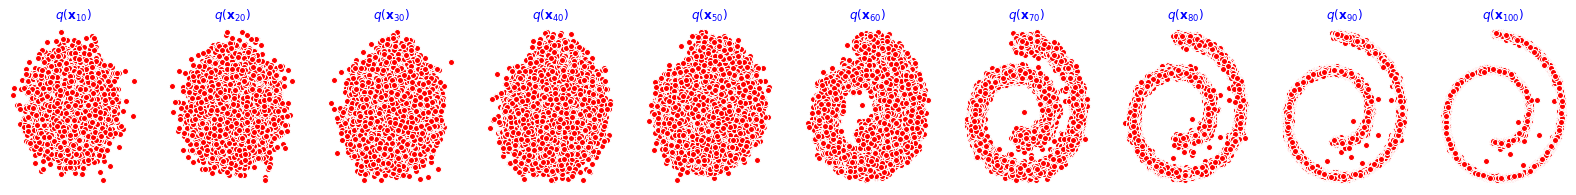

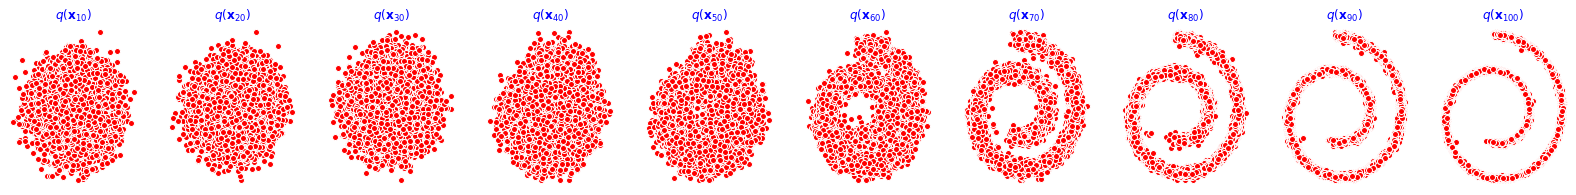

In [30]:
for t in range(num_epoch):
    # dataloader遍历
    for idx, batch_x in enumerate(dataloader):
        # 得到loss
        loss = diffusion_loss_fn(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        #梯度clip，保持稳定性
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()
    #每100步打印效果
    if (t % 100 == 0):
        print(loss)
        #根据参数采样一百个步骤的x，每隔十步画出来，迭代了4000个周期，逐渐更接近于原始
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)

        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i - 1].scatter(cur_x[:, 0], cur_x[:, 1], color='red', edgecolor='white');
            axs[i - 1].set_axis_off();
            axs[i - 1].set_title('$q(\mathbf{x}_{' + str(i * 10) + '})$')
plt.show()